## Data preprocessing, cleaning and merging

### Importing the Median House Income Data 

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

DATA_Rent = pd.read_csv("csv/sub-borougharea-medianrentall2017.csv",na_values=[''])

dt_num_rent = DATA_Rent.loc[:,['2000', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
               '2016']]
dt_num_rent.head()

,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,1711.171288,1411.54686,2138.913276,893.58885,2219.615916,989.738740,1530.785200,1275.798000,1355.465800,1517.640840,1295.420160,2734.069036,2583.599491
1,798.938959,681.00945,940.489171,684.69795,858.691843,983.033210,1026.749203,951.729628,1121.544175,995.320072,1050.429851,1109.910423,1070.552275
2,1459.571726,1423.92885,1744.710829,800.74845,1713.967139,1909.374770,1808.238010,1964.161829,1251.199200,1486.877850,1214.456400,2257.951473,2275.688265
3,1765.610959,1362.01890,1904.095152,1369.39590,2057.899416,2158.818030,2124.846885,1541.589250,1303.332500,1230.519600,1518.070500,2517.651962,2582.579918
4,1471.342466,780.06537,1626.693430,823.95855,1703.717502,1937.720595,1701.215292,1969.581702,1771.083028,1855.770092,1823.290320,1857.064607,2199.220246


In [5]:
DATA_Rent.head()

,short_name,long_name,Sub-Borough Area,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,rent_gross_med_adj,"Median rent, all ($2017)",Greenwich Village/Financial District,1711.171288,1411.54686,2138.913276,893.58885,2219.615916,989.738740,1530.785200,1275.798000,1355.465800,1517.640840,1295.420160,2734.069036,2583.599491
1,rent_gross_med_adj,"Median rent, all ($2017)",Lower East Side/Chinatown,798.938959,681.00945,940.489171,684.69795,858.691843,983.033210,1026.749203,951.729628,1121.544175,995.320072,1050.429851,1109.910423,1070.552275
2,rent_gross_med_adj,"Median rent, all ($2017)",Chelsea/Clinton/Midtown,1459.571726,1423.92885,1744.710829,800.74845,1713.967139,1909.374770,1808.238010,1964.161829,1251.199200,1486.877850,1214.456400,2257.951473,2275.688265
3,rent_gross_med_adj,"Median rent, all ($2017)",Stuyvesant Town/Turtle Bay,1765.610959,1362.01890,1904.095152,1369.39590,2057.899416,2158.818030,2124.846885,1541.589250,1303.332500,1230.519600,1518.070500,2517.651962,2582.579918
4,rent_gross_med_adj,"Median rent, all ($2017)",Upper West Side,1471.342466,780.06537,1626.693430,823.95855,1703.717502,1937.720595,1701.215292,1969.581702,1771.083028,1855.770092,1823.290320,1857.064607,2199.220246


In [6]:
DATA_Rent.shape

(55, 16)

In [7]:
dt_num_rent.shape

(55, 13)

In [8]:
DATA_Rent
dt_chg_rent = dt_num_rent.divide(dt_num_rent.loc[:, '2000'], axis=0)
dt_chg_rent_melt = pd.melt(dt_chg_rent, var_name='Year', value_name='Rent_Pct').drop('Year', 1)
# dt_chg_rent_melt

### Massaging the data and Feature engineering

In [9]:
dt_chg_rent = dt_num_rent.divide(dt_num_rent.loc[:, '2000'], axis=0)
dt_chg_rent_melt = pd.melt(dt_chg_rent, var_name='Year', value_name='Rent_Pct').drop('Year', 1)
dt_rent = pd.melt(DATA_Rent, id_vars=['short_name', 'long_name', 'Sub-Borough Area'],var_name='Year', value_name='Rent')
dt_rent = pd.concat([dt_rent, dt_chg_rent_melt], axis=1)
yr_chg_mean = dt_chg_rent.mean(0).reset_index()
yr_chg_mean.columns = ['Year', 'yr_mean']
dt_rent = pd.merge(dt_rent, yr_chg_mean, on='Year')
dt_rent['delta'] = dt_rent.loc[:, 'Rent_Pct'] - dt_rent.loc[:, 'yr_mean']
#if the increase in rent is greater than the average increment, then set the cumm growth flag to 1 else 0
dt_rent['growth_flag'] = (dt_rent['delta'] > 0).astype(int)
sum_consec = 0
for br in dt_rent.loc[:, 'Sub-Borough Area'].unique():
    for yr in ['2000', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015','2016']:
        if float(dt_rent.loc[(dt_rent['Year'] == yr) & (dt_rent['Sub-Borough Area'] == br), 'delta']) > 0:
            sum_consec += 1
        else:
            sum_consec = 0
        dt_rent.loc[(dt_rent['Year'] == yr) & (dt_rent['Sub-Borough Area'] == br), 'cumm_growth_yr'] = sum_consec


### Gentrification Function

In [10]:
def paint(ls):
    rtn = []
    yr = 0
    yr2 = 0
    flag = True
    while len(ls) != 0:
        if ls[-1] >= 4:
            rtn = rtn + list(zip(['Gentrifying'] * int(ls[-1]), range(ls[-1], 0, -1)))       
            flag = False
            ls = ls[:len(ls) - ls[-1]]
        elif ls[-1] < 4 and flag == True:
            rtn.append(['Gentrified', yr])
            yr += 1
            ls.pop()
        elif ls[-1] < 4 and flag == False:
            rtn.append(['Non-Gentrified', yr2])
            yr2 += 1
            ls.pop()
    rtn.reverse()
    rtn = pd.DataFrame(np.array(rtn), columns=['gentrify_flag', 'passed_years'])
    rtn.passed_years = rtn.passed_years.astype(int)
    rtn.loc[rtn['gentrify_flag'] == 'Non-Gentrified', 'passed_years'] = \
    yr2 - rtn.loc[rtn['gentrify_flag'] == 'Non-Gentrified', 'passed_years']
    rtn.loc[rtn['gentrify_flag'] == 'Gentrified', 'passed_years'] = \
    yr - rtn.loc[rtn['gentrify_flag'] == 'Gentrified', 'passed_years']
    return rtn

In [11]:
dt_rent = dt_rent.sort_values(by=['Sub-Borough Area', 'Year']).reset_index(drop=True)
dt_rent
pd.set_option('display.max_rows', None)
dt_rent

,short_name,long_name,Sub-Borough Area,Year,Rent,Rent_Pct,yr_mean,delta,growth_flag,cumm_growth_yr
0,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2000,1103.506849,1.000000,1.000000,0.000000,0,0.0
1,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2005,1064.851140,0.964970,0.864442,0.100528,1,1.0
2,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2006,1243.441051,1.126809,1.123537,0.003271,1,2.0
3,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2007,1021.244400,0.925454,0.834253,0.091200,1,3.0
4,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2008,1291.454309,1.170318,1.162781,0.007537,1,4.0
5,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2009,1354.930434,1.227841,1.189087,0.038753,1,5.0
6,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2010,1423.625116,1.290092,1.218645,0.071447,1,6.0
7,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2011,1400.495079,1.269131,1.217063,0.052068,1,7.0
8,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2012,1452.160514,1.315951,1.216676,0.099275,1,8.0
9,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2013,1440.704894,1.305570,1.233681,0.071889,1,9.0


In [12]:
dt_rent = dt_rent.sort_values(by=['Sub-Borough Area', 'Year']).reset_index(drop=True)
tmp = pd.DataFrame([])
for br in dt_rent.loc[:, 'Sub-Borough Area'].unique():
    ls = dt_rent.loc[dt_rent['Sub-Borough Area'] == br, 'cumm_growth_yr'].astype(int).tolist()
    tmp = pd.concat([tmp, paint(ls)])

dt_rent = pd.concat([dt_rent, tmp.reset_index(drop=True)], axis=1)
dt_rent.head()

,short_name,long_name,Sub-Borough Area,Year,Rent,Rent_Pct,yr_mean,delta,growth_flag,cumm_growth_yr,gentrify_flag,passed_years
0,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2000,1103.506849,1.000000,1.000000,0.000000,0,0.0,Non-Gentrified,1
1,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2005,1064.851140,0.964970,0.864442,0.100528,1,1.0,Gentrifying,1
2,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2006,1243.441051,1.126809,1.123537,0.003271,1,2.0,Gentrifying,2
3,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2007,1021.244400,0.925454,0.834253,0.091200,1,3.0,Gentrifying,3
4,rent_gross_med_adj,"Median rent, all ($2017)",Astoria,2008,1291.454309,1.170318,1.162781,0.007537,1,4.0,Gentrifying,4


### Importing and cleaning Median Household Income data

In [13]:
DATA_Income = pd.read_csv('csv/sub-borougharea-medianhouseholdincome2017.csv',na_values=[''])
                          # parse_dates=[2, 12],
                          # index_col=[0]
                          
dt_num_income = DATA_Income.loc[:, ['2000', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
                 '2016']]

dt_pvt_flag = pd.concat([DATA_Income.loc[:, 'Sub-Borough Area'],
                         dt_num_income.loc[:, '2000'] <= dt_num_income.loc[:, '2000'].quantile(0.4)
                         ], axis=1)
dt_pvt_flag.columns = ['Sub-Borough Area', 'Poverty_flag']

dt_income = pd.melt(DATA_Income, id_vars=['short_name', 'long_name', 'Sub-Borough Area'], var_name='Year', value_name='Income')
dt_income = pd.merge(dt_income, dt_pvt_flag, on='Sub-Borough Area')
# dt_income = pd.concat([dt_income, dt_chg_rent_melt], axis=1)
dt_income = dt_income.sort_values(by=['Sub-Borough Area', 'Year']).reset_index(drop=True)
# dt_income.to_csv(data_dir + '/dt_income.csv')
# dt_income = pd.concat([dt_income, dt_chg_income_melt], axis=1)
dt_income_rent = pd.concat([dt_rent, dt_income], axis=1)
dt_income_rent = dt_income_rent.iloc[:, list(range(2, 12)) + [16, 17]]
# dt_income_rent = pd.merge(dt_income_rent, dt_pvt_flag, on='Sub-Borough Area')

for br in dt_income_rent.loc[dt_income_rent['Poverty_flag'] == True, 'Sub-Borough Area'].unique():
    if len(dt_income_rent.loc[(dt_income_rent['Sub-Borough Area'] == br) &
                              (dt_income_rent['gentrify_flag'] == 'Gentrified'), :]) == 13:
        dt_income_rent.loc[dt_income_rent['Sub-Borough Area'] == br, 'gentrify_flag'] = 'Non-Gentrified'

### - Poverty Flag
# dt_income_rent.loc['Poverty'] = dt_income_rent.loc[]

#dt_income_rent.to_csv(data_dir + '/dt_income_rent.csv')



## Big Merge

In [14]:
DATA_Gen = pd.read_csv('csv/dt_mrg.csv')
DATA_Gen.head()

,Unnamed: 0,Sub-Borough Area,Year,Rent,Rent_Pct,yr_mean,delta,growth_flag,cumm_growth_yr,gentrify_flag,...,umemploy,popdensity,foreign,born.in.state,carfree.commute,commute.time,perform.eng,perform.math,serious.crime.rate,home.ownership.rate
0,0,Astoria,2000,1103.506849,1.000000,1.000000,0.000000,0,0.0,Non-Gentrified,...,0.078154,36.905274,0.460420,0.416547,0.709237,36.182040,0.0,0.0,11.106903,0.199976
1,1,Astoria,2005,1064.851140,0.964970,0.864442,0.100528,1,1.0,Gentrifying,...,0.075328,36.905274,0.461911,0.416547,0.745206,35.443453,0.0,0.0,11.106903,0.222814
2,2,Astoria,2006,1243.441051,1.126809,1.123537,0.003271,1,2.0,Gentrifying,...,0.101195,36.905274,0.462094,0.423218,0.774524,36.259592,0.0,0.0,11.106903,0.203166
3,3,Astoria,2007,1021.244400,0.925454,0.834253,0.091200,1,3.0,Gentrifying,...,0.063924,36.905274,0.474749,0.399320,0.759993,37.144401,0.0,0.0,10.619260,0.232038
4,4,Astoria,2008,1291.454309,1.170318,1.162781,0.007537,1,4.0,Gentrifying,...,0.064042,34.622640,0.423454,0.423790,0.768563,37.297014,0.0,0.0,10.335196,0.229757


In [15]:
DATA_Gen.shape

(364, 26)

## Selecting Important features and correlation 

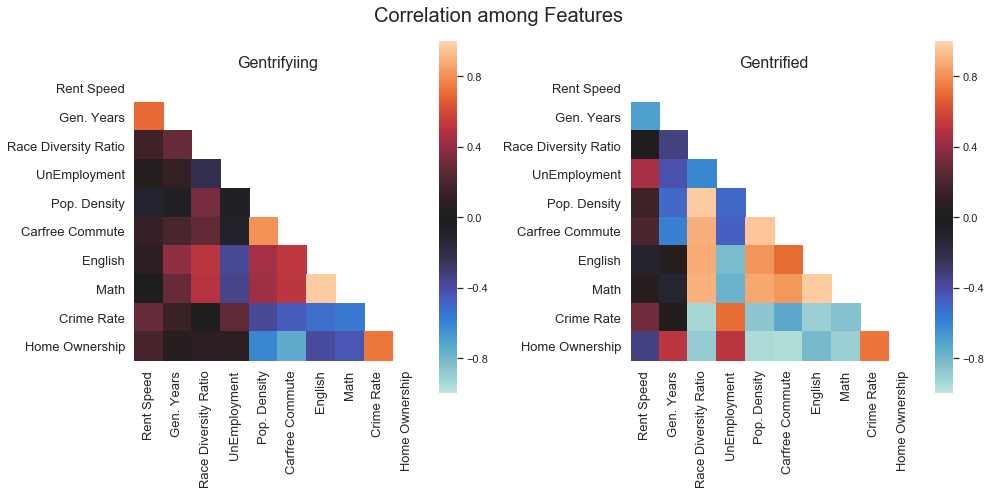

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots
import matplotlib.gridspec as gridspec
sns.set(style='whitegrid', palette="Set1", color_codes=False)
from sklearn import tree
#import graphviz
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score


DATA_Gen = pd.read_csv('csv/dt_mrg.csv', index_col=0)

'''
['Sub-Borough Area', 'Year', 'Rent', 'Rent_Pct', 'yr_mean', 'delta',
       'growth_flag', 'cumm_growth_yr', 'gentrify_flag', 'passed_years',
       'Income', 'Poverty_flag', 'hh18.count', 'hhsingle.count', 'raceindex',
       'umemploy', 'popdensity', 'foreign', 'born.in.state', 'carfree.commute',
       'commute.time', 'perform.eng', 'perform.math', 'serious.crime.rate',
       'home.ownership.rate']
'''

dt_train = DATA_Gen.loc[DATA_Gen['Poverty_flag'] == True, :]  # Poor Brs.
sr_growing_br = dt_train.loc[DATA_Gen['gentrify_flag'] == 'Gentrifying', :] \
    .groupby('Sub-Borough Area').agg({'growth_flag': 'sum'})
sr_growing_br.mean()

### - Heat Map


fig = plt.figure(figsize=(14, 7))
fig.suptitle('Correlation among Features', fontsize=20)
gs1 = gridspec.GridSpec(1, 2)
ax_list = [fig.add_subplot(ss) for ss in gs1]
plt_ind = 0
gen_ls = ['Gentrifying', 'Gentrified']
labs = ['Rent Speed',
        'Gen. Years',
        'Race Diversity Ratio',
        'UnEmployment', 'Pop. Density',
        'Carfree Commute',
        'English', 'Math',
        'Crime Rate',
        'Home Ownership']
important_feature_ls = ['delta',
                        'passed_years',
                        'raceindex',
                        'umemploy', 'popdensity',
                        'carfree.commute',
                        'perform.eng', 'perform.math',
                        'serious.crime.rate',
                        'home.ownership.rate']
for gen_flag in gen_ls:
    dt_tmp = dt_train.loc[DATA_Gen['gentrify_flag'] == gen_flag,important_feature_ls]
    corr = dt_tmp.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.set_style(style='dark')
    with sns.axes_style("white"):
        sns.heatmap(corr, mask=mask,
                    vmin=-1, vmax=1,
                    square=True,
                    xticklabels=labs,
                    yticklabels=labs,
                    center=0,
                    ax=ax_list[plt_ind]
                    # cmap="YlGnBu"
                    )
    plt_ind += 1
    # ax_list[plt_ind].set_title('Feature Correlation: In Gentrification', fontdict={'fontsize': '14'})
for ax in ax_list:
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(13)

ax_list[0].set_title('Gentrifyiing', fontdict={'fontsize': '16'})
ax_list[1].set_title('Gentrified', fontdict={'fontsize': '16'})

gs1.tight_layout(fig, rect=[0, 0.03, 1, 0.95])
plt.show()
